# Latent CCM : A Simple Worked-out Example

In this notebook, we will use a simple RNN to model the dynamics of 2 Lorenz attractors. We then show that using that reconstruction, we can infer the causal direction.

For sake of simplicity and illustration, we'll only use regularly sampled time series here. The general irregular case is discussed in details in the paper.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
from latentccm import causal_inf
import torch
from latentccm import DATADIR
from latentccm.datagen_utils import generate_Lorenz_data

## Data Generation

We use 2 Lorenz dynamical systems $X$ and $Y$ with unidirectional coupling. In our example, we set : 

$$ Y \rightarrow X$$

So Y is causing the X. The exact dynamical system is as follows : 

$$ \frac{dX_0}{dt} = \sigma (X_1-X_0) + c_{Y\rightarrow X} (X_1-Y_0) $$
$$ \frac{dX_1}{dt} = X_0 \cdot (\rho-X_2)-X_1 $$
$$ \frac{dX_2}{dt} = (X_0 \cdot X_1 - \beta X_2) $$
$$ \frac{dY_0}{dt} = \sigma (Y_1-Y_0) + c_{X\rightarrow Y} (Y_1-X_0)  $$
$$ \frac{dY_1}{dt} = Y_0 \cdot (\rho-Y_2)-Y_1 $$
$$ \frac{dY_2}{dt} = (Y_0\cdot Y_1 - \beta Y_2) $$

We set $c_{Y\rightarrow X}=3.5$ and $c_{X\rightarrow Y} = 0$ such that the coupling and the causal link is unidirectional. We further use the following parameters : 

$$\sigma = 10$$
$$\rho = 28$$
$$\beta = 8/3$$

In [4]:
_, y,_ = generate_Lorenz_data()
X = y[:,:3]
Y = y[:,3:]

## Data Visualization

Below we plot the first samples of Y over the 3 dimensions.

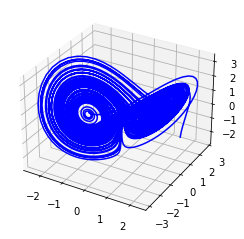

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(Y[:10000,0],Y[:10000,1],Y[:10000,2],color = "blue")

## Modelling the dynamics

We first subsample the data to lower resolution. We then learn a GRU to model the dynamics of X and Y separetely.

Once the models are trained, we 

In [13]:
X_tensor = torch.stack(torch.Tensor(X[::10,:]).chunk(1000))
Y_tensor = torch.stack(torch.Tensor(Y[::10,:]).chunk(1000))

datasetX = torch.utils.data.TensorDataset(X_tensor)
datasetY = torch.utils.data.TensorDataset(Y_tensor)

dlX = torch.utils.data.DataLoader(datasetX, batch_size = 32, shuffle = False)
dlY = torch.utils.data.DataLoader(datasetY, batch_size = 32, shuffle = False)

In [15]:
class GRU_reconstruction(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.RNN = torch.nn.GRU(input_size = 3, hidden_size = hidden_size, num_layers = 1)
        self.output_layer = torch.nn.Linear(hidden_size,3)
    def forward(self,x):
        output, _  = self.RNN(x)
        output = self.output_layer(output)
        return output
    
    def hidden_only(self,x):
        output, _  = self.RNN(x)
        return output

In [16]:
# Simplest train loop
dls = {"X":dlX, "Y":dlY}
hiddens = {}
for side in ["X","Y"]:
    loss_criterion = torch.nn.MSELoss()
    model = GRU_reconstruction(hidden_size = 20)
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
    for epoch in range(50):
        train_loss = 0
        for i,b in enumerate(dls[side]):
            optimizer.zero_grad()
            y_hat = model(b[0])
            loss1 = loss_criterion(y_hat[:,:-1,:],b[0][:,1:,:])
            loss2 = loss_criterion(y_hat[:,:-2,:],b[0][:,2:,:])
            loss = (loss1)# + 0.5*loss2)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach()
        train_loss /= (i+1)
        if (epoch%10)==0:
            print(f"Training_loss at epoch {epoch}: {train_loss}")

    hidden_path = []
    for i,b in enumerate(dls[side]):
        optimizer.zero_grad()
        y_hat = model.hidden_only(b[0])#[:,:,:]
        hidden_path.append(y_hat.detach())

    hiddens[side] = torch.cat(hidden_path).reshape(-1,y_hat.shape[-1])

Training_loss at epoch 0: 0.5703192949295044
Training_loss at epoch 10: 0.01695907860994339
Training_loss at epoch 20: 0.010898826643824577
Training_loss at epoch 30: 0.009309157729148865
Training_loss at epoch 40: 0.008712000213563442
Training_loss at epoch 0: 0.5319268703460693
Training_loss at epoch 10: 0.0032219444401562214
Training_loss at epoch 20: 0.0012014447711408138
Training_loss at epoch 30: 0.0007100770017132163
Training_loss at epoch 40: 0.0005554507370106876


## Computing the Cross Mapping between Latent Processes

Finally, we compute the correlation score of the reconstruction between the latent processes of $X$ and $Y$. We observe a clear signal for a reconstruction from $X$ to $Y$, suggesting a causal effect from $Y$ to $X$.

$$ Y \rightarrow X $$

In accordance with the generated data.

In [21]:
sc1, sc2 = causal_inf.CCM_compute(hiddens["X"].numpy()[::10],hiddens["Y"].numpy()[::10])

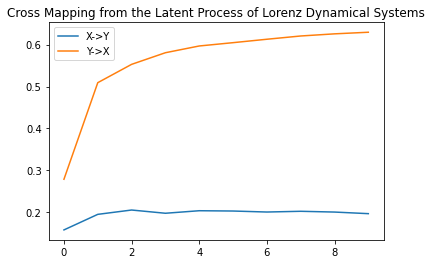

In [22]:
plt.figure()
plt.plot(sc1,label="X->Y")
plt.plot(sc2,label = "Y->X")
plt.legend()
plt.title("Cross Mapping from the Latent Process of Lorenz Dynamical Systems")
plt.show()

#### For more information : https://openreview.net/forum?id=4TSiOTkKe5P